**Purpose**

We want to be able to predict the number of points an fpl player will get.
Then we would want to be able to get the best teams

All imports here

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import requests
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import pickle as pkl
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Experiment with merged gw files**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/merged_gw_2022-23.csv')#22-23 data

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/merged_gw_23-34.csv')#23-24

In [ ]:
df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  object 
 1   position                    26505 non-null  object 
 2   team                        26505 non-null  object 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals              26505 non-null  float64
 13  expected_goals_conceded     265

In [ ]:
df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Nathan Redmond,MID,Southampton,1.5,0,0,3,0,0.0,403,...,4,0.0,1,0,0,0,55,False,0,1
1,Junior Stanislas,MID,Bournemouth,1.1,0,0,3,0,0.0,58,...,2,0.0,1,0,0,0,50,True,0,1
2,Armando Broja,FWD,Chelsea,2.0,0,0,3,0,0.3,150,...,0,19.0,1,0,0,0,55,False,0,1
3,Fabian Schär,DEF,Newcastle,2.4,0,3,43,1,14.6,366,...,2,25.0,15,0,0,0,45,True,0,1
4,Jonny Evans,DEF,Leicester,1.9,0,0,15,0,1.3,249,...,2,0.0,1,0,0,0,45,True,0,1


In [ ]:
df = df.sort_values(by=['name', 'GW']).reset_index(drop=True)

In [ ]:
df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [ ]:
df.describe()

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
count,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,26505.000000,...,26505.000000,26505.000000,26505.000000,26505.000000,2.650500e+04,2.650500e+04,2.650500e+04,26505.000000,26505.000000,26505.000000
mean,1.229708,0.034975,0.091945,5.174080,0.087191,3.986636,352.155442,0.016567,0.041239,0.027600,...,1.219694,1.628825,4.106206,1.196906,2.104428e+03,1.612256e+04,1.401812e+04,49.188304,0.051651,21.219279
std,2.085657,0.197954,0.455495,9.092054,0.282120,9.797862,206.078173,0.067103,0.148375,0.120924,...,1.188182,1.402969,11.287927,2.355236,7.691967e+04,6.821878e+04,5.738149e+04,11.288173,0.221325,10.734836
min,-3.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-4.000000,-2.180978e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-1.087000e+03,2.700000e+01,9.200000e+01,43.000000,0.000000,13.000000
50%,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,349.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-5.400000e+01,3.010000e+02,8.010000e+02,45.000000,0.000000,22.000000
75%,1.900000,0.000000,0.000000,8.000000,0.000000,1.400000,524.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,1.000000,3.300000e+01,3.885000e+03,6.310000e+03,51.000000,0.000000,30.000000
max,23.600000,3.000000,3.000000,102.000000,1.000000,124.000000,778.000000,1.285270,2.380000,2.370000,...,6.000000,9.000000,169.000000,23.000000,1.332069e+06,1.384843e+06,2.233619e+06,131.000000,1.000000,38.000000


**Feature Engineering**

We are creating the features that we would use to predict. We would be using the averages from the last games (if the player has played less than 38 games) or the last 38 games if the player has played up to 38 or more.


The averages we are using are:


*   Average Points
*   Average Minutes
*   Average ICT Index
*   Average Bonus
*   Average bps
*   Average expected points
*   Average expected goal involvements
*   Average expected goals conceded
*   average goals conceded





In [ ]:
window_size = 38
df[f'avg_points_last_{window_size}'] = df.groupby(['name'])['total_points'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean().shift(1))
df[f'avg_minutes_last_{window_size}'] = df.groupby(['name'])['minutes'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_ict_index_last_{window_size}'] = df.groupby(['name'])['ict_index'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_bonus_last_{window_size}'] = df.groupby(['name'])['bonus'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_bps_last_{window_size}'] = df.groupby(['name'])['bps'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_xP_last_{window_size}'] = df.groupby(['name'])['xP'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_expected_goal_involvements_last_{window_size}'] = df.groupby(['name'])['expected_goal_involvements'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_expected_goals_conceded_last_{window_size}'] = df.groupby(['name'])['expected_goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_goals_conceded_last_{window_size}'] = df.groupby(['name'])['goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))


df[f'avg_goals_scored_last_{window_size}'] = df.groupby(['name'])['goals_scored'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_influence_last_{window_size}'] = df.groupby(['name'])['influence'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_threat_last_{window_size}'] = df.groupby(['name'])['threat'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_creativity_last_{window_size}'] = df.groupby(['name'])['creativity'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))

We are also dividing the opposition team into a three categories. Top 6 teams (teams placed between 1 and 6 in the table).

Mid Table teams (teams between placed from 7 to 14 in the table)

Relegation fodder (teams placed from 15 oo 20th in the table)

In [ ]:
bins = [0, 6, 14, 20]
labels = ['top 6', 'mid table', 'relegation fodder']

df['team_category'] = pd.cut(df['opponent_team'], bins=bins, labels=labels, right=True)

In [ ]:
df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW',
       'avg_points_last_38', 'avg_minutes_last_38', 'avg_ict_index_last_38',
       'avg_bonus_last_38', 'avg_bps_last_38', 'avg_xP_last_38',
       'avg_expected_goal_involvements_last_38',
       'avg_expected_goals_conceded_last_38', 'avg_goals_conceded_last_38',
       'avg_goals_scored_last_38', 'avg_influence_last_38',
       'avg_threat_last_38', 'avg_crea

In [ ]:
useless_columns = [
    'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'expected_assists',
    'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'fixture',  'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score','threat', 'transfers_balance', 'transfers_in',
       'transfers_out', 'yellow_cards', 'GW'
]

In [ ]:
df.drop(columns = useless_columns, inplace = True)

In [ ]:
df[f'avg_points_last_{window_size}'] = df[f'avg_points_last_{window_size}'].fillna(0)
df[f'avg_minutes_last_{window_size}'] = df[f'avg_minutes_last_{window_size}'].fillna(0)
df[f'avg_ict_index_last_{window_size}'] = df[f'avg_ict_index_last_{window_size}'].fillna(0)
df[f'avg_bonus_last_{window_size}'] = df[f'avg_bonus_last_{window_size}'].fillna(0)
df[f'avg_bps_last_{window_size}'] = df[f'avg_bps_last_{window_size}'].fillna(0)
df[f'avg_xP_last_{window_size}'] = df[f'avg_xP_last_{window_size}'].fillna(0)
df[f'avg_expected_goal_involvements_last_{window_size}'] = df[f'avg_expected_goal_involvements_last_{window_size}'].fillna(0)
df[f'avg_expected_goals_conceded_last_{window_size}'] = df[f'avg_expected_goals_conceded_last_{window_size}'].fillna(0)
df[f'avg_goals_conceded_last_{window_size}'] = df[f'avg_goals_conceded_last_{window_size}'].fillna(0)

df[f'avg_goals_scored_last_{window_size}'] = df[f'avg_goals_scored_last_{window_size}'].fillna(0)
df[f'avg_influence_last_{window_size}'] = df[f'avg_influence_last_{window_size}'].fillna(0)
df[f'avg_threat_last_{window_size}'] = df[f'avg_threat_last_{window_size}'].fillna(0)
df[f'avg_creativity_last_{window_size}'] = df[f'avg_creativity_last_{window_size}'].fillna(0)

In [ ]:
df.head()

,name,position,opponent_team,total_points,value,was_home,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,team_category
0,Aaron Cresswell,DEF,13,1,50,True,0.00,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000,mid table
1,Aaron Cresswell,DEF,16,2,50,False,1.00,90.0,4.100,0.0,16.0,1.300000,0.0,0.0,2.000000,0.0,22.00,0.000000,18.700,relegation fodder
2,Aaron Cresswell,DEF,5,0,50,True,1.50,90.0,6.100,0.0,15.0,1.650000,0.0,0.0,1.500000,0.0,18.30,0.500000,42.250,top 6
3,Aaron Cresswell,DEF,2,6,50,False,1.00,90.0,6.300,0.0,12.0,1.433333,0.0,0.0,1.666667,0.0,15.60,6.333333,41.100,top 6
4,Aaron Cresswell,DEF,18,2,49,True,2.25,90.0,5.425,0.0,15.5,1.625000,0.0,0.0,1.250000,0.0,15.15,6.750000,32.275,relegation fodder


There are four positions. The scoring for each position is different. Hence in predicting the scores, we need to create four different models for each position.

In [ ]:
fwd_df = df[df['position'] == 'FWD'].reset_index(drop = True)
mid_df = df[df['position'] == 'MID'].reset_index(drop = True)
def_df = df[df['position'] == 'DEF'].reset_index(drop = True)
gk_df = df[df['position'] == 'GK'].reset_index(drop = True)

The correlation matrices show how the important factors for a certain position's points differ

In [ ]:
corr_matrix = fwd_df.select_dtypes(include = np.number).corr()
corr_matrix['total_points'].sort_values(ascending = True)

opponent_team                             0.017229
avg_expected_goals_conceded_last_38       0.205430
avg_expected_goal_involvements_last_38    0.278139
value                                     0.378955
avg_goals_conceded_last_38                0.384434
avg_bonus_last_38                         0.405298
avg_goals_scored_last_38                  0.414982
avg_creativity_last_38                    0.420961
avg_threat_last_38                        0.437201
avg_influence_last_38                     0.452099
avg_bps_last_38                           0.454135
avg_minutes_last_38                       0.455059
avg_xP_last_38                            0.458962
avg_ict_index_last_38                     0.460307
avg_points_last_38                        0.467760
total_points                              1.000000
Name: total_points, dtype: float64

In [ ]:
corr_matrix = mid_df.select_dtypes(include = np.number).corr()
corr_matrix['total_points'].sort_values(ascending = True)

opponent_team                             0.011652
avg_expected_goals_conceded_last_38       0.255487
avg_expected_goal_involvements_last_38    0.309192
avg_bonus_last_38                         0.348031
value                                     0.363540
avg_goals_scored_last_38                  0.364659
avg_goals_conceded_last_38                0.420772
avg_threat_last_38                        0.465491
avg_creativity_last_38                    0.478189
avg_xP_last_38                            0.478222
avg_influence_last_38                     0.487657
avg_bps_last_38                           0.491464
avg_minutes_last_38                       0.501738
avg_points_last_38                        0.505247
avg_ict_index_last_38                     0.515389
total_points                              1.000000
Name: total_points, dtype: float64

In [ ]:
corr_matrix = def_df.select_dtypes(include = np.number).corr()
corr_matrix['total_points'].sort_values(ascending = True)

opponent_team                             0.021478
avg_goals_scored_last_38                  0.132332
avg_expected_goals_conceded_last_38       0.211815
avg_expected_goal_involvements_last_38    0.214427
value                                     0.266389
avg_bonus_last_38                         0.276023
avg_threat_last_38                        0.283267
avg_creativity_last_38                    0.295360
avg_goals_conceded_last_38                0.336338
avg_xP_last_38                            0.371354
avg_points_last_38                        0.387497
avg_ict_index_last_38                     0.391860
avg_influence_last_38                     0.395005
avg_minutes_last_38                       0.410971
avg_bps_last_38                           0.416528
total_points                              1.000000
Name: total_points, dtype: float64

In [ ]:
corr_matrix = gk_df.select_dtypes(include = np.number).corr()
corr_matrix['total_points'].sort_values(ascending = True)

avg_threat_last_38                        0.015958
opponent_team                             0.017110
avg_expected_goal_involvements_last_38    0.179847
avg_creativity_last_38                    0.297842
avg_expected_goals_conceded_last_38       0.321264
avg_bonus_last_38                         0.440943
value                                     0.490785
avg_goals_conceded_last_38                0.537313
avg_xP_last_38                            0.552065
avg_points_last_38                        0.575165
avg_ict_index_last_38                     0.587697
avg_influence_last_38                     0.587875
avg_minutes_last_38                       0.601381
avg_bps_last_38                           0.601595
total_points                              1.000000
avg_goals_scored_last_38                       NaN
Name: total_points, dtype: float64

**Processing the test df**

In [ ]:
test_df = test_df.sort_values(by=['name', 'GW']).reset_index(drop=True)

In [ ]:
window_size = 38
test_df[f'avg_points_last_{window_size}'] = test_df.groupby(['name'])['total_points'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean().shift(1))
test_df[f'avg_minutes_last_{window_size}'] = test_df.groupby(['name'])['minutes'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_ict_index_last_{window_size}'] = test_df.groupby(['name'])['ict_index'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_bonus_last_{window_size}'] = test_df.groupby(['name'])['bonus'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_bps_last_{window_size}'] = test_df.groupby(['name'])['bps'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_xP_last_{window_size}'] = test_df.groupby(['name'])['xP'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_expected_goal_involvements_last_{window_size}'] = test_df.groupby(['name'])['expected_goal_involvements'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_expected_goals_conceded_last_{window_size}'] = test_df.groupby(['name'])['expected_goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_goals_conceded_last_{window_size}'] = test_df.groupby(['name'])['goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_goals_scored_last_{window_size}'] = test_df.groupby(['name'])['goals_scored'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_influence_last_{window_size}'] = test_df.groupby(['name'])['influence'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_threat_last_{window_size}'] = test_df.groupby(['name'])['threat'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
test_df[f'avg_creativity_last_{window_size}'] = test_df.groupby(['name'])['creativity'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))

test_df[f'avg_points_last_{window_size}'] = test_df[f'avg_points_last_{window_size}'].fillna(0)
test_df[f'avg_minutes_last_{window_size}'] = test_df[f'avg_minutes_last_{window_size}'].fillna(0)
test_df[f'avg_ict_index_last_{window_size}'] = test_df[f'avg_ict_index_last_{window_size}'].fillna(0)
test_df[f'avg_bonus_last_{window_size}'] = test_df[f'avg_bonus_last_{window_size}'].fillna(0)
test_df[f'avg_bps_last_{window_size}'] = test_df[f'avg_bps_last_{window_size}'].fillna(0)
test_df[f'avg_xP_last_{window_size}'] = test_df[f'avg_xP_last_{window_size}'].fillna(0)
test_df[f'avg_expected_goal_involvements_last_{window_size}'] = test_df[f'avg_expected_goal_involvements_last_{window_size}'].fillna(0)
test_df[f'avg_expected_goals_conceded_last_{window_size}'] = test_df[f'avg_expected_goals_conceded_last_{window_size}'].fillna(0)
test_df[f'avg_goals_conceded_last_{window_size}'] = test_df[f'avg_goals_conceded_last_{window_size}'].fillna(0)
test_df[f'avg_goals_scored_last_{window_size}'] = test_df[f'avg_goals_scored_last_{window_size}'].fillna(0)
test_df[f'avg_influence_last_{window_size}'] = test_df[f'avg_influence_last_{window_size}'].fillna(0)
test_df[f'avg_threat_last_{window_size}'] = test_df[f'avg_threat_last_{window_size}'].fillna(0)
test_df[f'avg_creativity_last_{window_size}'] = test_df[f'avg_creativity_last_{window_size}'].fillna(0)

In [ ]:
test_df.drop(columns = useless_columns, inplace= True)

In [ ]:
bins = [0, 6, 14, 20]
labels = ['top 6', 'mid table', 'relegation fodder']

test_df['team_category'] = pd.cut(test_df['opponent_team'], bins=bins, labels=labels, right=True)

In [ ]:
test_df.head()

,name,position,opponent_team,total_points,value,was_home,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,team_category
0,Aaron Connolly,FWD,12,0,45,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mid table
1,Aaron Connolly,FWD,20,0,45,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,relegation fodder
2,Aaron Connolly,FWD,19,0,45,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,relegation fodder
3,Aaron Connolly,FWD,15,0,45,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,relegation fodder
4,Aaron Connolly,FWD,14,0,45,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mid table


**We would test for each kind of player**

**Testing for forwards**

In [ ]:
x = fwd_df.drop(columns= ['name'])
x_test = test_df[test_df['name'] == 'Ollie Watkins'].reset_index(drop = True)

In [ ]:
y_test = x_test['total_points']
_y = x['total_points']
x.drop(columns = ['total_points','opponent_team', 'position'], inplace = True)
x_test.drop(columns = ['total_points', 'name', 'opponent_team', 'position'], inplace = True)

In [ ]:
x.head()

,value,was_home,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,team_category
0,55,False,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,relegation fodder
1,55,True,1.000000,45.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,2.0,0.0,0.000000,1.0,0.800,mid table
2,55,False,2.500000,37.000000,1.650000,0.0,7.500000,2.0,0.0,0.0,1.0,0.0,8.700000,2.5,5.950,mid table
3,55,True,2.333333,47.666667,1.366667,0.0,6.666667,2.1,0.0,0.0,1.0,0.0,6.666667,3.0,4.400,mid table
4,55,True,2.250000,54.750000,2.525000,0.0,7.000000,2.0,0.0,0.0,1.0,0.0,7.400000,8.5,9.725,top 6


In [ ]:
x_test.head()

,value,was_home,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,team_category
0,80,False,0.00,0.000000,0.000000,0.0,0.000000,0.000,0.000,0.000,0.00,0.0,0.000000,0.000000,0.000000,relegation fodder
1,80,True,5.00,90.000000,8.500000,0.0,18.000000,2.100,0.330,3.440,5.00,0.0,32.200000,29.000000,23.400000,mid table
2,80,False,5.00,81.500000,6.850000,0.0,14.500000,3.550,0.265,2.040,2.50,0.0,19.700000,20.500000,27.900000,top 6
3,80,False,5.00,82.666667,8.266667,0.0,12.333333,4.200,0.440,1.490,2.00,0.0,20.066667,35.333333,26.866667,mid table
4,80,True,4.25,80.000000,6.725000,0.0,9.750000,4.075,0.385,1.705,2.25,0.0,15.050000,29.000000,23.100000,mid table


**Processing Pipeline**

In [ ]:
scaler = MinMaxScaler()

In [ ]:
quant_features = x.select_dtypes(include = np.number).columns
print(quant_features)
quant_pipeline = Pipeline(steps = [
   ('imputer', SimpleImputer(strategy = 'median')),
   ('scaler', scaler)
])

cat_features = x.select_dtypes(include = ['object', 'bool', 'category']).columns
print(cat_features)
cat_pipeline = Pipeline(steps = [
    ('encoder', OneHotEncoder(sparse = False, drop = 'first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('quant', quant_pipeline, quant_features),
    ('cat', cat_pipeline, cat_features)
])

Index(['value', 'avg_points_last_38', 'avg_minutes_last_38',
       'avg_ict_index_last_38', 'avg_bonus_last_38', 'avg_bps_last_38',
       'avg_xP_last_38', 'avg_expected_goal_involvements_last_38',
       'avg_expected_goals_conceded_last_38', 'avg_goals_conceded_last_38',
       'avg_goals_scored_last_38', 'avg_influence_last_38',
       'avg_threat_last_38', 'avg_creativity_last_38'],
      dtype='object')
Index(['was_home', 'team_category'], dtype='object')


In [ ]:
feature_names = ['was_home_True', 'team_category_relegation fodder', 'team_category_top 6']

We would be trying to forecast the points for a specific player in 23/24 based on their 22/23 stats

In [ ]:
x = pd.DataFrame(preprocessor.fit_transform(x), columns = list(quant_features)+list(feature_names))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
x.head()

,value,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,was_home_True,team_category_relegation fodder,team_category_top 6
0,0.178571,0.071429,0.000000,0.000000,0.0,0.080645,0.050279,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0
1,0.178571,0.142857,0.500000,0.000000,0.0,0.080645,0.134078,0.0,0.0,0.50,0.0,0.000000,0.008929,0.022923,1.0,0.0,0.0
2,0.178571,0.250000,0.411111,0.088710,0.0,0.201613,0.217877,0.0,0.0,0.25,0.0,0.106098,0.022321,0.170487,0.0,0.0,0.0
3,0.178571,0.238095,0.529630,0.073477,0.0,0.188172,0.226257,0.0,0.0,0.25,0.0,0.081301,0.026786,0.126074,1.0,0.0,0.0
4,0.178571,0.232143,0.608333,0.135753,0.0,0.193548,0.217877,0.0,0.0,0.25,0.0,0.090244,0.075893,0.278653,1.0,0.0,1.0


In [ ]:
quant_x_test = pd.DataFrame(quant_pipeline.fit_transform(x_test.select_dtypes(include=np.number)), columns = list(quant_features))

quant_x_test['was_home_True']= cat_pipeline.fit_transform(pd.DataFrame({'was_home': x_test['was_home']}))
encoded_array = cat_pipeline.fit_transform(pd.DataFrame({'team_category':x_test['team_category']}))
encoded_df = pd.DataFrame(encoded_array, columns=cat_pipeline.get_feature_names_out(['team_category']))
x_test = pd.concat([quant_x_test, encoded_df], axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
x_test.head()

,value,avg_points_last_38,avg_minutes_last_38,avg_ict_index_last_38,avg_bonus_last_38,avg_bps_last_38,avg_xP_last_38,avg_expected_goal_involvements_last_38,avg_expected_goals_conceded_last_38,avg_goals_conceded_last_38,avg_goals_scored_last_38,avg_influence_last_38,avg_threat_last_38,avg_creativity_last_38,was_home_True,team_category_relegation fodder,team_category_top 6
0,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0000,0.000000,0.000000,0.0,1.0,0.0
1,0.090909,0.642857,1.000000,0.872434,0.0,0.673797,0.299525,0.466812,1.000000,1.00,0.0,0.9660,0.675728,0.838710,1.0,0.0,0.0
2,0.090909,0.642857,0.905556,0.703079,0.0,0.542781,0.506339,0.374864,0.593023,0.50,0.0,0.5910,0.477670,1.000000,0.0,0.0,1.0
3,0.090909,0.642857,0.918519,0.848485,0.0,0.461676,0.599049,0.622416,0.433140,0.40,0.0,0.6020,0.823301,0.962963,0.0,0.0,0.0
4,0.090909,0.546429,0.888889,0.690249,0.0,0.364973,0.581220,0.544614,0.495640,0.45,0.0,0.4515,0.675728,0.827957,1.0,0.0,0.0


In [ ]:
dTree  = DecisionTreeRegressor()

In [ ]:
dTree.fit(x, _y)

DecisionTreeRegressor()

In [ ]:
y_pred = dTree.predict(x_test)

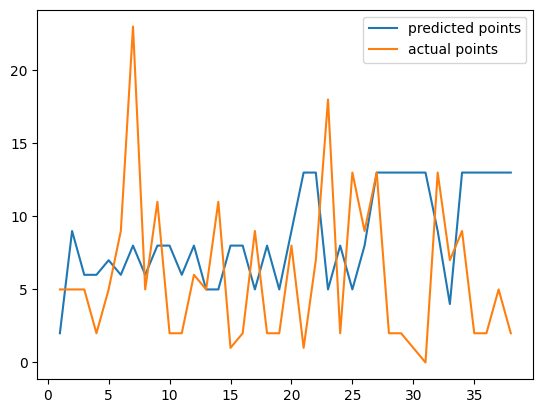

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 5.947368421052632,
Mean Squared Error = 52.68421052631579,
Root Mean Squared Error = 7.258388975958494



In [ ]:
model = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')

In [ ]:
model.fit(x,_y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:absoluteerror', ...),
             param_grid={'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_absolute_error')

In [ ]:
y_pred = model.predict(x_test)

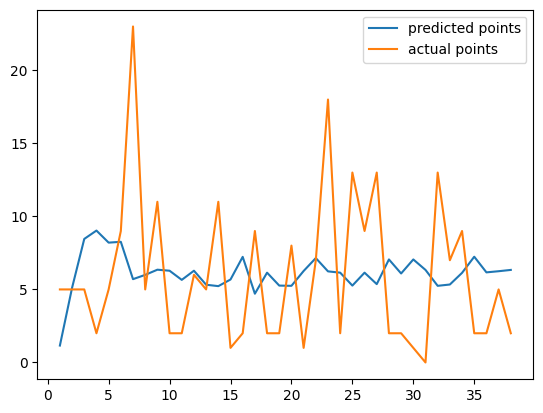

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 4.430470159179286,
Mean Squared Error = 30.051361760278844,
Root Mean Squared Error = 5.4819122357329695



In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
mlp.fit(x,_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [50, (50, 50)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [100, 200, 300, 400], 'solver': ['adam']},
             scoring='neg_mean_absolute_error')

In [ ]:
y_pred = mlp.predict(x_test)

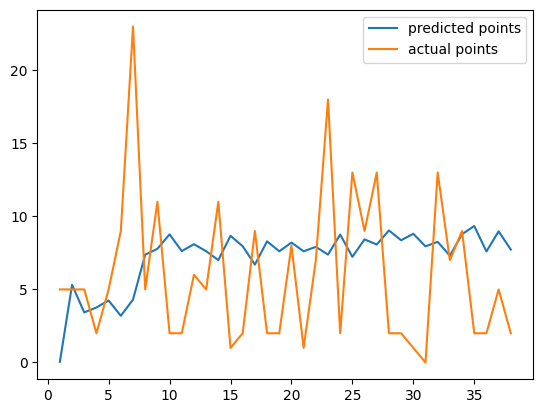

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 4.785887911074522,
Mean Squared Error = 35.18371688029706,
Root Mean Squared Error = 5.931586371308865



In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf.fit(x, _y)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [ ]:
y_pred = rf.predict(x_test)

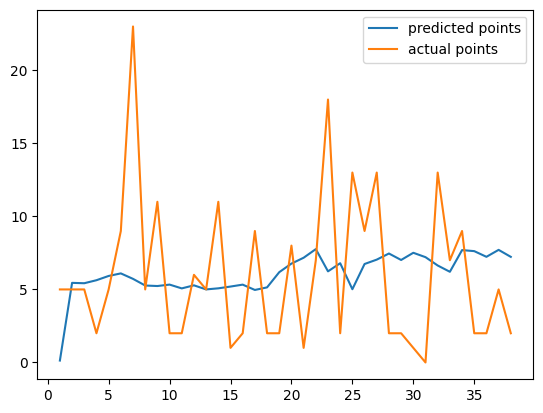

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 4.231848773817222,
Mean Squared Error = 28.90735339234655,
Root Mean Squared Error = 5.376555904326351



In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', mlp.best_estimator_),
    ('xgboost', model.best_estimator_),
    ('random_forest', rf.best_estimator_)
])

In [ ]:
final_model.fit(x, _y)
y_pred = final_model.predict(x_test)

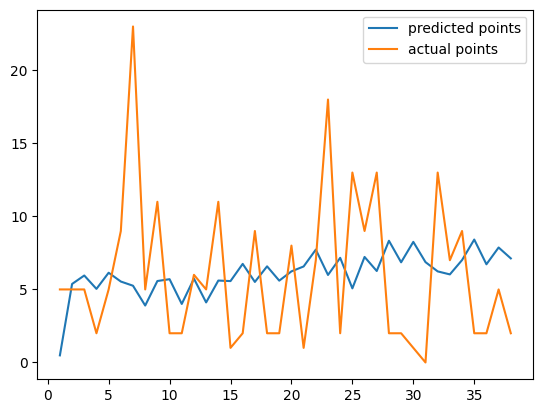

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 4.390472874960518,
Mean Squared Error = 30.415855573410514,
Root Mean Squared Error = 5.515057168643904



The voting regressor produces the least mean absolute error.

There is so much variance in the points, so the r2 score isn't the most appropriate metric

**Testing for midfielders**

In [ ]:
x = mid_df.drop(columns= ['name'])
x_test = test_df[test_df['name'] == 'Mohamed Salah'].reset_index(drop = True)

In [ ]:
y_test = x_test['total_points']
_y = x['total_points']
x.drop(columns = ['total_points','opponent_team', 'position'], inplace = True)
x_test.drop(columns = ['total_points', 'name', 'opponent_team', 'position'], inplace = True)

In [ ]:
x = pd.DataFrame(preprocessor.fit_transform(x), columns = list(quant_features)+list(feature_names))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
quant_x_test = pd.DataFrame(quant_pipeline.fit_transform(x_test.select_dtypes(include=np.number)), columns = list(quant_features))

quant_x_test['was_home_True']= cat_pipeline.fit_transform(pd.DataFrame({'was_home': x_test['was_home']}))
encoded_array = cat_pipeline.fit_transform(pd.DataFrame({'team_category':x_test['team_category']}))
encoded_df = pd.DataFrame(encoded_array, columns=cat_pipeline.get_feature_names_out(['team_category']))
x_test = pd.concat([quant_x_test, encoded_df], axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
dTree.fit(x, _y)

DecisionTreeRegressor()

In [ ]:
y_pred = dTree.predict(x_test)

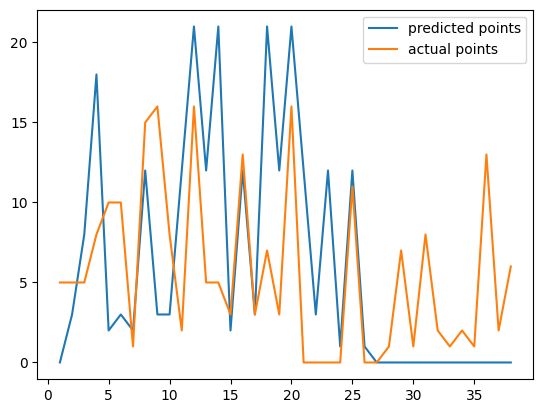

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 5.2368421052631575,
Mean Squared Error = 47.973684210526315,
Root Mean Squared Error = 6.926303791382985



In [ ]:
model = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')

In [ ]:
model.fit(x,_y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:absoluteerror', ...),
             param_grid={'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_absolute_error')

In [ ]:
y_pred = model.predict(x_test)

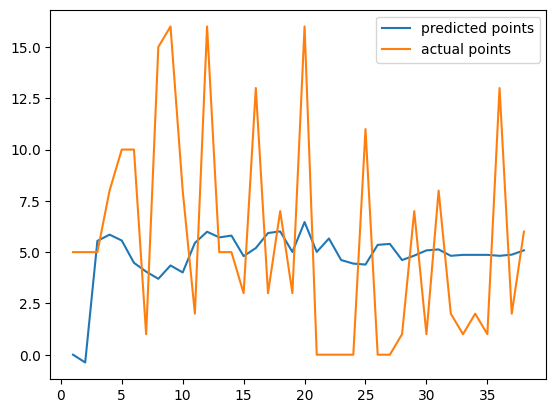

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")


Mean Absolute Error = 4.428648433278124,
Mean Squared Error = 27.4699112895296,
Root Mean Squared Error = 5.241174609715803



In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
mlp.fit(x,_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
y_pred = mlp.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf.fit(x, _y)

In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', mlp.best_estimator_),
    ('xgboost', model.best_estimator_),
    ('random_forest', rf.best_estimator_)
])

In [ ]:
final_model.fit(x, _y)
y_pred = final_model.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

**Testing for Defenders**

In [ ]:
x = def_df.drop(columns= ['name'])
x_test = test_df[test_df['name'] == 'Trent Alexander-Arnold'].reset_index(drop = True)

In [ ]:
y_test = x_test['total_points']
_y = x['total_points']
x.drop(columns = ['total_points','opponent_team', 'position'], inplace = True)
x_test.drop(columns = ['total_points', 'name', 'opponent_team', 'position'], inplace = True)

In [ ]:
x = pd.DataFrame(preprocessor.fit_transform(x), columns = list(quant_features)+list(feature_names))

In [ ]:
quant_x_test = pd.DataFrame(quant_pipeline.fit_transform(x_test.select_dtypes(include=np.number)), columns = list(quant_features))

quant_x_test['was_home_True']= cat_pipeline.fit_transform(pd.DataFrame({'was_home': x_test['was_home']}))
encoded_array = cat_pipeline.fit_transform(pd.DataFrame({'team_category':x_test['team_category']}))
encoded_df = pd.DataFrame(encoded_array, columns=cat_pipeline.get_feature_names_out(['team_category']))
x_test = pd.concat([quant_x_test, encoded_df], axis = 1)

In [ ]:
dTree.fit(x, _y)

In [ ]:
y_pred = dTree.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
model = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')

In [ ]:
model.fit(x,_y)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
mlp.fit(x,_y)

In [ ]:
y_pred = mlp.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf.fit(x, _y)

In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', mlp.best_estimator_),
    ('xgboost', model.best_estimator_),
    ('random_forest', rf.best_estimator_)
])

In [ ]:
final_model.fit(x, _y)
y_pred = final_model.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

**Goal Keepers**

In [ ]:
x = gk_df.drop(columns= ['name'])
x_test = test_df[test_df['name'] == 'Jordan Pickford'].reset_index(drop = True)

In [ ]:
y_test = x_test['total_points']
_y = x['total_points']
x.drop(columns = ['total_points','opponent_team', 'position'], inplace = True)
x_test.drop(columns = ['total_points', 'name', 'opponent_team', 'position'], inplace = True)

In [ ]:
x = pd.DataFrame(preprocessor.fit_transform(x), columns = list(quant_features)+list(feature_names))

In [ ]:
quant_x_test = pd.DataFrame(quant_pipeline.fit_transform(x_test.select_dtypes(include=np.number)), columns = list(quant_features))

quant_x_test['was_home_True']= cat_pipeline.fit_transform(pd.DataFrame({'was_home': x_test['was_home']}))
encoded_array = cat_pipeline.fit_transform(pd.DataFrame({'team_category':x_test['team_category']}))
encoded_df = pd.DataFrame(encoded_array, columns=cat_pipeline.get_feature_names_out(['team_category']))
x_test = pd.concat([quant_x_test, encoded_df], axis = 1)

In [ ]:
dTree.fit(x, _y)

In [ ]:
y_pred = dTree.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
model = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
model = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')

In [ ]:
model.fit(x,_y)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
mlp.fit(x,_y)

In [ ]:
y_pred = mlp.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf.fit(x, _y)

In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', mlp.best_estimator_),
    ('xgboost', model.best_estimator_),
    ('random_forest', rf.best_estimator_)
])

In [ ]:
final_model.fit(x, _y)
y_pred = final_model.predict(x_test)

In [ ]:
plt.plot(range(1,39), y_pred, label = 'predicted points')
plt.plot(range(1,39), y_test, label = 'actual points')
plt.legend()
plt.show()

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, y_test)},
Mean Squared Error = {mean_squared_error(y_pred, y_test)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, y_test))}
""")

**Making the models to to forecast 24/25 points**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/merged_gw_2022-23.csv')#22-23 data
df['season'] = 0

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/merged_gw_23-34.csv')#23-24
test_df['season'] = 1

In [ ]:
df = pd.concat([df, test_df]).reset_index(drop = True)

In [ ]:
df = df.sort_values(by=['name','season', 'GW']).reset_index(drop =True)

In [ ]:
window_size = 38
df[f'avg_points_last_{window_size}'] = df.groupby(['name'])['total_points'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean().shift(1))
df[f'avg_minutes_last_{window_size}'] = df.groupby(['name'])['minutes'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_ict_index_last_{window_size}'] = df.groupby(['name'])['ict_index'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_bonus_last_{window_size}'] = df.groupby(['name'])['bonus'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_bps_last_{window_size}'] = df.groupby(['name'])['bps'].transform(lambda x: x.rolling(window=window_size, min_periods = 1).mean().shift(1))
df[f'avg_xP_last_{window_size}'] = df.groupby(['name'])['xP'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_expected_goal_involvements_last_{window_size}'] = df.groupby(['name'])['expected_goal_involvements'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_expected_goals_conceded_last_{window_size}'] = df.groupby(['name'])['expected_goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_goals_conceded_last_{window_size}'] = df.groupby(['name'])['goals_conceded'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))


df[f'avg_goals_scored_last_{window_size}'] = df.groupby(['name'])['goals_scored'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_influence_last_{window_size}'] = df.groupby(['name'])['influence'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_threat_last_{window_size}'] = df.groupby(['name'])['threat'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))
df[f'avg_creativity_last_{window_size}'] = df.groupby(['name'])['creativity'].transform(lambda x: x.rolling(window = window_size, min_periods = 1).mean().shift(1))

In [ ]:
bins = [0, 6, 14, 20]
labels = ['top 6', 'mid table', 'relegation fodder']

df['team_category'] = pd.cut(df['opponent_team'], bins=bins, labels=labels, right=True)

In [ ]:
useless_columns = [
    'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'expected_assists',
    'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'fixture',  'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score','threat', 'transfers_balance', 'transfers_in',
       'transfers_out', 'yellow_cards', 'GW'
]

In [ ]:
df.drop(columns = useless_columns, inplace = True)

In [ ]:
df[f'avg_points_last_{window_size}'] = df[f'avg_points_last_{window_size}'].fillna(0)
df[f'avg_minutes_last_{window_size}'] = df[f'avg_minutes_last_{window_size}'].fillna(0)
df[f'avg_ict_index_last_{window_size}'] = df[f'avg_ict_index_last_{window_size}'].fillna(0)
df[f'avg_bonus_last_{window_size}'] = df[f'avg_bonus_last_{window_size}'].fillna(0)
df[f'avg_bps_last_{window_size}'] = df[f'avg_bps_last_{window_size}'].fillna(0)
df[f'avg_xP_last_{window_size}'] = df[f'avg_xP_last_{window_size}'].fillna(0)
df[f'avg_expected_goal_involvements_last_{window_size}'] = df[f'avg_expected_goal_involvements_last_{window_size}'].fillna(0)
df[f'avg_expected_goals_conceded_last_{window_size}'] = df[f'avg_expected_goals_conceded_last_{window_size}'].fillna(0)
df[f'avg_goals_conceded_last_{window_size}'] = df[f'avg_goals_conceded_last_{window_size}'].fillna(0)

df[f'avg_goals_scored_last_{window_size}'] = df[f'avg_goals_scored_last_{window_size}'].fillna(0)
df[f'avg_influence_last_{window_size}'] = df[f'avg_influence_last_{window_size}'].fillna(0)
df[f'avg_threat_last_{window_size}'] = df[f'avg_threat_last_{window_size}'].fillna(0)
df[f'avg_creativity_last_{window_size}'] = df[f'avg_creativity_last_{window_size}'].fillna(0)

In [ ]:
df.drop(columns = ['season', 'name', 'opponent_team'], inplace= True)

In [ ]:
fwd_df = df[df['position'] == 'FWD'].reset_index(drop = True)
mid_df = df[df['position'] == 'MID'].reset_index(drop = True)
def_df = df[df['position'] == 'DEF'].reset_index(drop = True)
gk_df = df[df['position'] == 'GK'].reset_index(drop = True)

In [ ]:
y_fwd = fwd_df['total_points']
y_mid = mid_df['total_points']
y_def = def_df['total_points']
y_gk = gk_df['total_points']

In [ ]:
fwd_df.drop(columns = ['position', 'total_points'], inplace= True)
mid_df.drop(columns = ['position', 'total_points'], inplace= True)
def_df.drop(columns = ['position', 'total_points'], inplace= True)
gk_df.drop(columns = ['position', 'total_points'], inplace= True)

**Preprocessing pipeline**

In [ ]:
scaler = MinMaxScaler()

In [ ]:
quant_features = fwd_df.select_dtypes(include = np.number).columns
print(quant_features)
quant_pipeline = Pipeline(steps = [
   ('imputer', SimpleImputer(strategy = 'median')),
   ('scaler', scaler)
])

cat_features = fwd_df.select_dtypes(include = ['object', 'bool', 'category']).columns
print(cat_features)
cat_pipeline = Pipeline(steps = [
    ('encoder', OneHotEncoder(sparse = False, drop = 'first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('quant', quant_pipeline, quant_features),
    ('cat', cat_pipeline, cat_features)
])

**Training the model for forwards**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

fwd_df.columns

In [ ]:
fwd_df = pd.DataFrame(preprocessor.fit_transform(fwd_df), columns = list(quant_features)+list(feature_names))

In [ ]:
with open('forward_pipeline.pkl', 'wb') as file:
  pkl.dump(preprocessor, file)

In [ ]:
fwd_df.columns

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(fwd_df, y_fwd, test_size = 0.2, random_state = 42)

In [ ]:
f_xgb = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
f_xgb = GridSearchCV(f_xgb, parameters, scoring='neg_mean_absolute_error')

In [ ]:
f_xgb.fit(Xtrain,Ytrain)

In [ ]:
y_pred = f_xgb.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
f_mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
f_mlp.fit(Xtrain, Ytrain)

In [ ]:
y_pred = f_mlp.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf_fwd = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf_fwd.fit(Xtrain, Ytrain)
y_pred = rf_fwd.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', f_mlp.best_estimator_),
    ('xgboost', f_xgb.best_estimator_),
    ('random_forest', rf_fwd.best_estimator_)
])

In [ ]:
final_model.fit(Xtrain, Ytrain)
y_pred = final_model.predict(Xtest)

In [ ]:
final_forward_model = final_model

In [ ]:
with open('forward_model.pkl', 'wb') as file:
  pkl.dump(final_forward_model, file)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

**Midfielder Model**

In [ ]:
mid_df.columns

In [ ]:
mid_df = pd.DataFrame(preprocessor.fit_transform(mid_df), columns = list(quant_features)+list(feature_names))

In [ ]:
with open('midfield_pipeline.pkl', 'wb') as file:
  pkl.dump(preprocessor, file)

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(mid_df, y_mid, test_size = 0.2, random_state = 42)

In [ ]:
m_xgb = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
m_xgb = GridSearchCV(m_xgb, parameters, scoring='neg_mean_absolute_error')

In [ ]:
m_xgb.fit(Xtrain,Ytrain)

In [ ]:
y_pred = m_xgb.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
m_mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
m_mlp.fit(Xtrain, Ytrain)

In [ ]:
y_pred = m_mlp.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf_mid = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf_mid.fit(Xtrain, Ytrain)
y_pred = rf_mid.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', m_mlp.best_estimator_),
    ('xgboost', m_xgb.best_estimator_),
    ('random_forest', rf_mid.best_estimator_)
])

In [ ]:
final_model.fit(Xtrain, Ytrain)
y_pred = final_model.predict(Xtest)

In [ ]:
final_midfielder_model = final_model

In [ ]:
with open('midfield_model.pkl', 'wb') as file:
  pkl.dump(final_midfielder_model, file)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

**Defenders Model**

In [ ]:

def_df.columns

In [ ]:
def_df = pd.DataFrame(preprocessor.fit_transform(def_df), columns = list(quant_features)+list(feature_names))

In [ ]:
with open('defender_pipeline.pkl', 'wb') as file:
  pkl.dump(preprocessor, file)

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(def_df, y_def, test_size = 0.2, random_state = 42)

In [ ]:
d_xgb = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
d_xgb = GridSearchCV(d_xgb, parameters, scoring='neg_mean_absolute_error')

In [ ]:
d_xgb.fit(Xtrain,Ytrain)

In [ ]:
y_pred = d_xgb.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
d_mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
d_mlp.fit(Xtrain, Ytrain)

In [ ]:
y_pred = d_mlp.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf_def = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf_def.fit(Xtrain, Ytrain)
y_pred = rf_def.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', d_mlp.best_estimator_),
    ('xgboost', d_xgb.best_estimator_),
    ('random_forest', rf_def.best_estimator_)
])

In [ ]:
final_model.fit(Xtrain, Ytrain)
y_pred = final_model.predict(Xtest)

In [ ]:
final_defender_model = final_model

In [ ]:
with open('defender_model.pkl', 'wb') as file:
  pkl.dump(final_defender_model, file)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

**Goal Keeper Model**

In [ ]:
gk_df.columns

In [ ]:
gk_df.head()

In [ ]:
gk_df = pd.DataFrame(preprocessor.fit_transform(gk_df), columns = list(quant_features)+list(feature_names))

In [ ]:
with open('gk_pipeline.pkl', 'wb') as file:
  pkl.dump(preprocessor, file)

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(gk_df, y_gk, test_size = 0.2, random_state = 42)

In [ ]:
g_xgb = XGBRegressor(objective = 'reg:absoluteerror')

In [ ]:
parameters = {
    'n_estimators': [100,200,300,400]
}

In [ ]:
g_xgb = GridSearchCV(g_xgb, parameters, scoring='neg_mean_absolute_error')

In [ ]:
g_xgb.fit(Xtrain,Ytrain)

In [ ]:
y_pred = g_xgb.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters  ={
    'hidden_layer_sizes': [(50), (50,50)],
    'max_iter': [100,200,300,400],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]

}

In [ ]:
g_mlp = GridSearchCV(MLPRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
g_mlp.fit(Xtrain, Ytrain)

In [ ]:
y_pred = g_mlp.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
parameters = {
    'n_estimators': [100,200,300],
    'max_depth': [5,10, 15, 20]
}

In [ ]:
rf_gk = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error')

In [ ]:
rf_gk.fit(Xtrain, Ytrain)
y_pred = rf_gk.predict(Xtest)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
final_model = VotingRegressor(estimators = [
    ('feed_forward_network', g_mlp.best_estimator_),
    ('xgboost', g_xgb.best_estimator_),
    ('random_forest', rf_gk.best_estimator_)
])

In [ ]:
final_model.fit(Xtrain, Ytrain)
y_pred = final_model.predict(Xtest)

In [ ]:
final_goalKeeper_model = final_model

In [ ]:
with open('goalkeeper_model.pkl', 'wb') as file:
  pkl.dump(final_goalKeeper_model, file)

In [ ]:
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred, Ytest)},
Mean Squared Error = {mean_squared_error(y_pred, Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred, Ytest))}
""")

In [ ]:
new = {'_id':'66afbcfa4dc15cf114c7cce8', 'name': 'Erling Haaland', 'position': 'FWD', 'opponent_team': 4, 'total_points': 0, 'value': 124, 'was_home': True, 'season': 1, 'avg_points_last_38': 7.2105263157894735, 'avg_minutes_last_38': 75.1842105263158,
'avg_ict_index_last_38': 9.505263157894737, 'avg_bonus_last_38': 1.0526315789473684, 'avg_bps_last_38': 27.263157894736842, 'avg_xP_last_38': 10.131578947368421, 'avg_expected_goal_involvements_last_38': 0.5160581578947369, 'avg_expected_goals_conceded_last_38': 0.46295, 'avg_goals_conceded_last_38': 0.7105263157894737, 'avg_goals_scored_last_38': 0.9473684210526315, 'avg_influence_last_38': 36.578947368421055, 'avg_threat_last_38': 48.89473684210526, 'avg_creativity_last_38': 9.842105263157896, 'team_category': 'top 6'}
new = pd.DataFrame.from_dict({0: new}, orient='index')

In [ ]:
new.drop(columns = ['_id', 'name', 'position', 'opponent_team', 'total_points', 'season'], inplace = True)

In [ ]:
new['was_home'] = True

In [ ]:
new = pd.DataFrame(preprocessor.transform(new), columns = list(quant_features)+feature_names)

In [ ]:
new

In [ ]:
final_forward_model.predict(new)

In [ ]:
import numpy
print(numpy.__version__)